# Entropic map: properties and examples

## Aim of the notebook and theoretical background

This notebook is based on the results of presented in: *Entropic estimation of optimal transport maps*, by Aram-Alexandre Pooladian, Jonathan Niles-Weed


We considere the $\textit{Monge problem}$, given the two probability distributions P and Q, and the quadratic loss: 

\begin{equation} 
    \min_{T \in \mathcal{T}(P,Q)} \int \frac{1}{2} \lVert x-T(x) \rVert _2^2 dP(x)
\end{equation}

and let be $T_0$ a solution we want to estimate, given the independantly drawn samples, X1, ..., XN ~ P and Y1, ..., Yn ~ Q. Finding a solution is computationaly demanding. 

Empirically, REF proposes to considere a new equation easier to solve, by adding an $\textit{entropic regularization term}$, with $\epsilon >0$ and the Kullback-Leibler divergence $\mathcal{D}_{KL}$, giving:

\begin{equation}
  S_\epsilon(P,Q) = \inf_{\pi \in \Pi(P,Q)} \int \int \frac{1}{2} \lVert x-y \rVert_2^2 d\pi(x,y) + \epsilon \mathcal{D}_{KL}(\pi \Vert P \otimes Q)
\end{equation}

The empirical strategy is thus to obtain an estimate of this solution $T_\epsilon$, with $\epsilon → 0$. To obtain such estimate, let's consider the dual expression associated with the primal one above:

\begin{equation}
  S_\epsilon(P,Q) = \inf_{f \in \mathcal{L}^2(P), g \in \mathcal{L}^2(Q)} \int p dP + \int q dQ  - \epsilon \int \int e^{(f(x) + g(y) - \frac{1}{2} \lVert x-y \rVert_2^2 )} dP(x)dQ(y) + \epsilon
\end{equation}

Let's consider $\pi_\epsilon $ an optimal $\textit{entropic plan}$, solution of the primal, and $(f_\epsilon, g_\epsilon)$ the $\textit{entropic potentials}$, the associated solution of the dual. 

Finally, let's consider the $\textit{entropic map}$  $T_\epsilon$ defined as the $\textit{barycentric projection}$ of the $\textit{entropic plan}$ $\pi_\epsilon$:

\begin{equation} 
  T_\epsilon(x) = \int y d\pi_\epsilon^x(y) = \mathbb{E}_{\pi_\epsilon} [Y \vert X=x]
\end{equation}

The article proposes an estimator for the optimal map based on that $\textit{entropic map}$, by functionning in two steps on a dataset of size $n$. 

First, we estimate the empirical $\textit{entropic potentials}$ $f_{\epsilon, (n,n)}$ and $g_{\epsilon, (n,n)}$ by using the Sinkhorn's algorithm. Then, we compute the estimation $T_{\epsilon,(n,n)}$ of $T_\epsilon$, using the approximation, that $\forall x \in \mathbb{R}^d$:

\begin{equation}
\frac{\int y e^{\frac{1}{\epsilon} (g_\epsilon(x) - \frac{1}{2}\lVert x-y\rVert _2^2)}dQ(y)}{\int e^{\frac{1}{\epsilon} (g_\epsilon(x) - \frac{1}{2}\lVert x-y\rVert_2 ^2)}dQ(y)}=T_\epsilon(x) \approx T_{\epsilon, (n,n)}(x) = \frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\epsilon} (g_{\epsilon, (n,n)}(Y_i) - \frac{1}{2} \lVert x - Y_i \rVert_2^2)} }{\frac{1}{n} \sum_{i=1}^n e^{\frac{1}{\epsilon} (g_{\epsilon, (n,n)}(Y_i) - \frac{1}{2} \lVert x - Y_i \rVert_2^2)}}
\end{equation}

Finally, the paper uses that $T_\epsilon ⟶_{\epsilon →0} T_0$ and that $T_{\epsilon, (n,n)} ⟶_{n → ∞} T_\epsilon$, to find $∀ n$, the optimal $\epsilon$ to obtain a great estimate $\hat{T} = T_{\epsilon, (n,n)}$ of $T_0$, and demonstrates some convergence theoremes. 



In [6]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main
    %pip install -q nilearn
    %pip install -q SCOT
    %pip install -q geopandas

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 107.0 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import nilearn
from nilearn import datasets, image, plotting
from nilearn.image import get_data

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.problems.quadratic import quadratic_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot
import numpy as np

from ott.problems.linear import potentials

import time
import pandas as pd
import random
#import SCOT.src
#from SCOT.src import evals
#from SCOT.src.scot import SCOT


## Synthetical data

In a first step, we will illustrate the results of the article (cite) with synthetic data generated following the protocol of the article. That is, we generate a sample of $n$ data of $\mathbb{R}^d$ with distribution $P$ , the source distribution. We then apply a transformation, $T_0:\mathbb{R}^d→\mathbb{R}^d$ to these random variables, to obtain a new set of random variables of law $Q=(T_0)\#P$ .  $Q$ is the target distribution. The transformation $T_0$ is chosen to be monotonic on a coordinate-by-coordinate basis, so as to ensure that the transport plan $T_0$ from $P$ to $Q$ is optimal for the Monge Problem, thus allowing the calculated transport plans to be compared to the optimal reference plan.


In the article P takes value in $[-1, 1]^d$, so we let $P = \mathcal{U}([-1, 1]^d)$



Then , the article propose two settings for $T_0$:



*   $T_0= T_1: x \rightarrow \exp(x)$ coordinate-wise
*   $T_0= T_2: x \rightarrow 3 x^2 \ sign(x)$ coordinate-wise



It is to be noticed that the weights are uniformly distributed in x and y. Otherwise $T_0$ would not remain a general solution of Monge's Problem.

In [3]:
def generate_source(n, dim, T, rng):
  x = 2*(jax.random.uniform(rng, (n, dim))-1/2)
  y = T(x)
  return x, y

def T_1(x):
  return jnp.exp(x)

def T_2(x):
  return 3*x**2*jnp.sign(x)

## First example of entropic map

We can compute and test the entropic map with  2 samples of 100 data points x, y, with both $T_1$ and $T_2$ and considering $\epsilon = 0.1$.

The first data set $x, y$ is used to compute the dual using a Sinkhorn algorithm on these distributions. These duals are then used to compute the entropic potentials of the problem.

The second data set $x_1, y_1$ is then used to test the entropic map. As the data have the same distribution, we expect the entropic potentials to transport $x_1$ close to $y_1$.

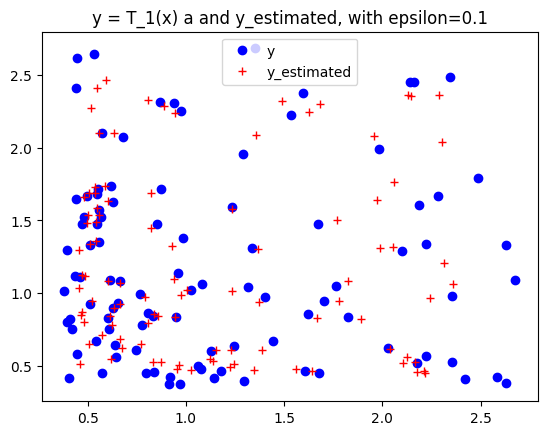

In [4]:
rng = jax.random.PRNGKey(0)
rng1 = jax.random.PRNGKey(1)

x, y = generate_source(100, 2, T_1, rng)
# Generating data to compute the entropic map

x1, y1 = generate_source(100, 2, T_1, rng1)
# Generating data to test the entropic map

geometrie = pointcloud.PointCloud( x = x, y = y, epsilon = 0.1)
problem = linear_problem.LinearProblem(geom = geometrie)
solver = sinkhorn.Sinkhorn()
ot_sink = solver(problem)

entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = problem)
y_eps = entropic_pot.transport(vec = x1)

plt.plot(y1[:,0], y1[:,1], 'bo', label = "y")
plt.plot(y_eps[:,0], y_eps[:,1], 'r+', label = "y_estimated")
plt.title("y = T_1(x) a and y_estimated, with epsilon=0.1")
plt.legend()
plt.show()

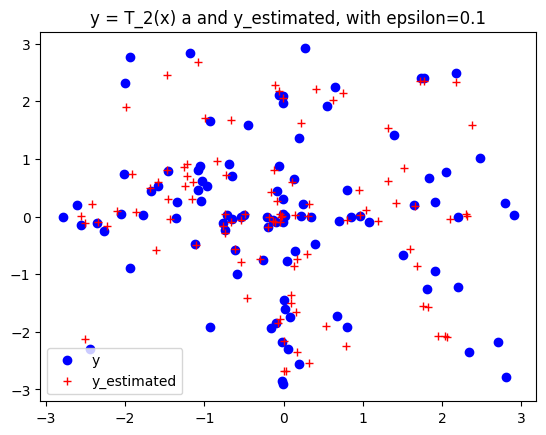

In [5]:
rng = jax.random.PRNGKey(0)
rng1 = jax.random.PRNGKey(1)

x, y = generate_source(100, 2, T_2, rng)
# Generating data to compute the entropic map

x1, y1 = generate_source(100, 2, T_2, rng1)
# Generating data to test the entropic map

geometrie = pointcloud.PointCloud( x = x, y = y, epsilon = 0.1)
problem = linear_problem.LinearProblem(geom = geometrie)
solver = sinkhorn.Sinkhorn()
ot_sink = solver(problem)

entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = problem)
y_eps = entropic_pot.transport(vec = x1)

plt.plot(y1[:,0], y1[:,1], 'bo', label = "y")
plt.plot(y_eps[:,0], y_eps[:,1], 'r+', label = "y_estimated")
plt.title("y = T_2(x) a and y_estimated, with epsilon=0.1")
plt.legend()
plt.show()

#Experiments: 







The article aims to estimate the true $T_0$ from a sample. So we use the empirical distributions:


*   $P_n=\frac{1}{n} \sum_{i=1}^{n} \delta_{X_i}$
*   $Q_n=\frac{1}{n} \sum_{i=1}^{n} \delta_{Y_i}$

For a given $\epsilon$, the entropic map between $P_n$ and $Q_n$, can be explicitely computed. It is denoted $T_{\epsilon, (n, n)}$. 

The paper demonstrates a number of properties of the estimator.


### Theorem 3: control over the error of $T_{\epsilon}$
<br>
Theorem 3 is crucial for controlling the error made by using $T_{epsilon}$ instead of $T_0$. 
It states that, under some conditions (that will be respected in the experiment):



> $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}  \lesssim (1 + I_0(P, Q))n^{-\frac{\bar{\alpha}+1}{2 (\bar{\alpha}+d'+1)}} \log(n)$

Where $\hat{T} = T_{\epsilon,(n,n)}$ from $P_n$ to $Q_n$, 
and $\epsilon \asymp n^{-\frac{1}{\bar{\alpha}+d'+1}} $,  and $\bar{\alpha}= α \wedge 3$, and $d'= 2\lceil d/2\rceil$









The following experiment is made to illustrate empirically this theorem:
<br>

1.   For a given set $(\alpha, n, d, T_0)$, we draw n i.i.d $X \sim P$, $Y = T_0(X)$, $X$ are $d$ dimensionnal, $\alpha$ is a  coefficient for an Hölder like condition
2.   $X$ and $Y$ are used to generate $P_n$ and $Q_n$ as explained above
3.   We set $\epsilon = n^{-\frac{1}{\bar{\alpha}+d'+1}}$ to compute  $\hat{T} = T_{\epsilon,(n,n)}$ 
4.   We evaluate the empirical MSE between $\hat{T}$ and $T_0$ on 1000 data points $X_1 \sim P, Y_1 = T_0(X_1)$. So we evaluate $||\hat{T}−T_0||^{2} _{L_2(P)}$ with a Monte-Carlo method for the computed $\hat{T}$
5.   Stages 1-4 are repeated in order to evaluate $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}$ by averaging
6.   Then we divide the estimate of $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}$ by $K_n=n^{-\frac{\bar{\alpha}+1}{2 (\bar{\alpha}+d'+1)}} \log(n)$ in order to illustrate the domination 

In [ ]:
def compute_epsilon(n, d, alpha):
  d_1 = 2*np.floor(d/2)
  alpha_1 = min(alpha, 3)
  return(n**(-1/(d_1+alpha_1+1)))

def compute_rate(n, d, alpha):
  d_1 = 2*np.floor(d/2)
  alpha_1 = min(alpha, 3)
  return(np.log(n)*n**(-(1+alpha_1)/(d_1+alpha_1+1)))

def experiment (T, d, nombre_tirage, n_monte_carlo, alpha):
  L = [10, 20, 30, 50, 100, 150, 200, 300, 500]
  result = []
  for i in L:
    SE = []
    for j in range (nombre_tirage):
      key = np.random.randint(1000000)
      rng = jax.random.PRNGKey(key)
      x, y = generate_source(int(i), d, T, rng)
      epsilon = compute_epsilon(int(i), d, alpha)
      geometrie = pointcloud.PointCloud( x = x, y = y, epsilon = 0.3*epsilon)
      problem = linear_problem.LinearProblem(geom = geometrie)
      solver = sinkhorn.Sinkhorn(parallel_dual_updates=True)
      ot_sink = solver(problem)

      entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = problem)

      
      key1 = np.random.randint(1000000)
      rng1 = jax.random.PRNGKey(key1)
      x1, y1  = generate_source(n_monte_carlo, d, T, rng1)
      y_eps = entropic_pot.transport(vec = x1)
      SE += [jnp.linalg.norm(y_eps-y1)**2/n_monte_carlo]
    result += [np.mean(SE)/compute_rate(int(i), d, alpha)]

  return L, result

In [ ]:
test_1 = experiment(T = T_2, d = 2, nombre_tirage = 20, n_monte_carlo=1000, alpha = 1)

In [ ]:
test_2 = experiment(T = T_2, d = 2, nombre_tirage = 20, n_monte_carlo=1000, alpha = 2)


In [ ]:
test_3 = experiment(T = T_1, d = 2, nombre_tirage = 20, n_monte_carlo=1000, alpha = 1)

In [ ]:
test_4 = experiment(T = T_1, d = 2, nombre_tirage = 20, n_monte_carlo=1000, alpha = 2)

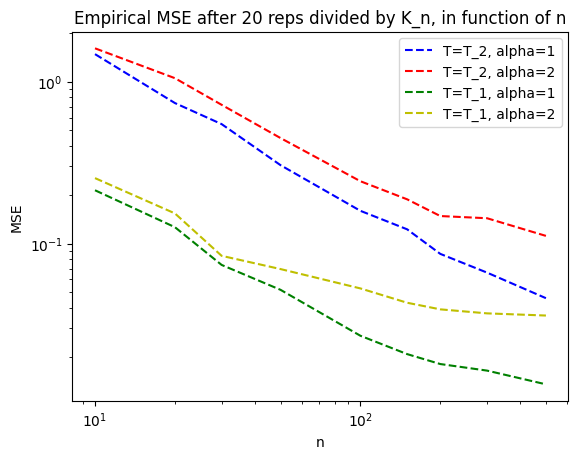

In [ ]:
plt.plot(test_1[0], test_1[1], 'b--', label = 'T=T_2, alpha=1')
plt.plot(test_2[0], test_2[1], 'r--', label = 'T=T_2, alpha=2')
plt.plot(test_3[0], test_3[1], 'g--', label = 'T=T_1, alpha=1')
plt.plot(test_4[0], test_4[1], 'y--', label = 'T=T_1, alpha=2')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('MSE')
plt.legend()
plt.title('Empirical MSE after 20 reps divided by K_n, in function of n')
plt.show()

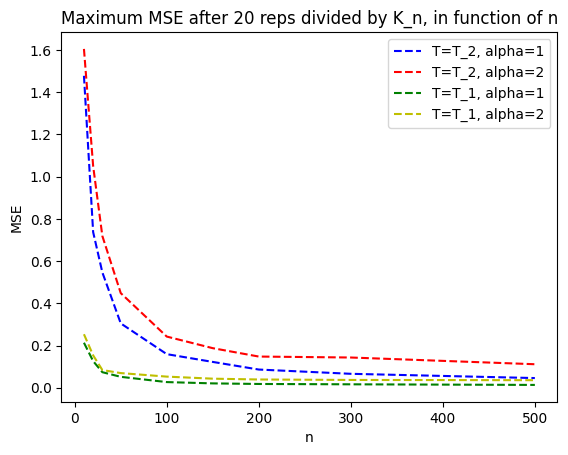

In [ ]:
plt.plot(test_1[0], test_1[1], 'b--', label = 'T=T_2, alpha=1')
plt.plot(test_2[0], test_2[1], 'r--', label = 'T=T_2, alpha=2')
plt.plot(test_3[0], test_3[1], 'g--', label = 'T=T_1, alpha=1')
plt.plot(test_4[0], test_4[1], 'y--', label = 'T=T_1, alpha=2')
plt.xlabel('n')
plt.ylabel('MSE')
plt.legend()
plt.title('Maximum MSE after 20 reps divided by K_n, in function of n')
plt.show()

This experiment illustrates empirically that: 


> $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}  \lesssim (1 + I_0(P, Q))n^{-\frac{\bar{\alpha}+1}{2 (\bar{\alpha}+d'+1)}} \log(n)$



## Convergence of the estimator when increasing the size of the source sample 

In the conditions above, $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}$ when $n \rightarrow \infty$.
We illustrate this convergence, with the following experiment.

1.   For a given set $(\epsilon, d, T_0)$, we draw $n$ i.i.d $X \sim P$, $Y = T_0(X)$, $X$ and $Y$ are $d$ dimensionnal
2.   $X$ and $Y$ are used to generate $P_n$ and $Q_n$ as explained above and we evaluate $\hat{T}$
3.   We evaluate the empirical MSE between $\hat{T}$ and $T_0$ on 1000 data points $X_1 \sim P, Y_1 = T_0(X_1)$. This is an estimator of $||\hat{T}−T_0||^{2} _{L_2(P)}$ 
4.   Stages 1-3 are repeated in order to evaluate $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}$ by averaging the empirical MSE
5.   Stages 1-4 are repeated with different values of $n$, so that we can illustrate the decrease of the expected MSE in n

In [ ]:
def experiment_error (T, d, nombre_tirage, n_monte_carlo):
  L = [10, 20, 30, 50, 100, 150, 200, 300, 500, 750, 1000, 1300]
  result = []
  for i in L:
    SE = []
    for j in range (nombre_tirage):
      key = np.random.randint(1000000)
      rng = jax.random.PRNGKey(key)
      x, y = generate_source(int(i), d, T, rng)
      geometrie = pointcloud.PointCloud( x = x, y = y, epsilon = 0.1)
      problem = linear_problem.LinearProblem(geom = geometrie)
      solver = sinkhorn.Sinkhorn(parallel_dual_updates=True)
      ot_sink = solver(problem)

      entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = problem)

      
      key1 = np.random.randint(1000000)
      rng1 = jax.random.PRNGKey(key1)
      x1, y1  = generate_source(n_monte_carlo, d, T, rng1)
      y_eps = entropic_pot.transport(vec = x1)
      SE += [jnp.linalg.norm(y_eps-y1)**2/n_monte_carlo]
    result += [np.mean(SE)]

  return L, result

In [ ]:
test_2_T1 = experiment_error(T = T_1, d = 2, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
test_5_T1 = experiment_error(T = T_1, d = 5, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
test_10_T1 = experiment_error(T = T_1, d = 10, nombre_tirage = 20, n_monte_carlo=1000)

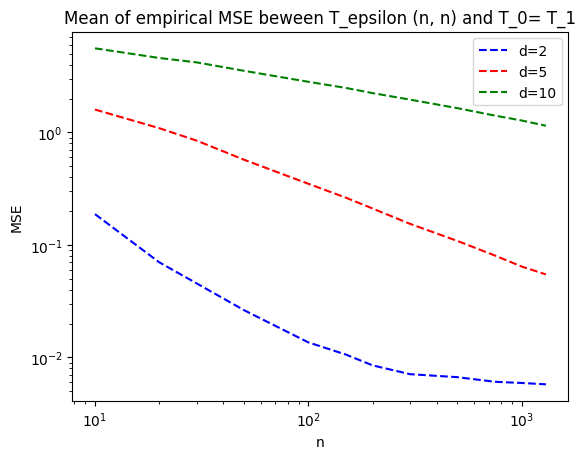

In [ ]:
plt.plot(test_2_T1[0], test_2_T1[1], 'b--', label ="d=2")
plt.plot(test_5_T1[0], test_5_T1[1], 'r--', label ="d=5")
plt.plot(test_10_T1[0], test_10_T1[1], 'g--', label ="d=10")
plt.legend()
plt.title('Mean of empirical MSE beween T_epsilon (n, n) and T_0= T_1')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
test_2_T2 = experiment_error(T = T_2, d = 2, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
test_5_T2 = experiment_error(T = T_2, d = 5, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
test_10_T2 = experiment_error(T = T_2, d = 10, nombre_tirage = 20, n_monte_carlo=1000)

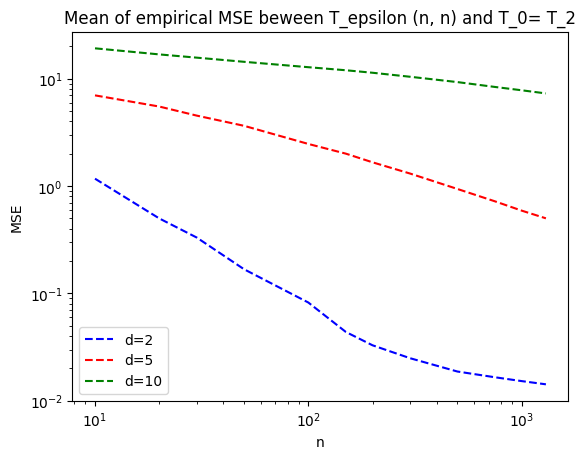

In [ ]:
plt.plot(test_2_T2[0], test_2_T2[1], 'b--', label ="d=2")
plt.plot(test_5_T2[0], test_5_T2[1], 'r--', label ="d=5")
plt.plot(test_10_T2[0], test_10_T2[1], 'g--', label ="d=10")
plt.legend()
plt.title('Mean of empirical MSE beween T_epsilon (n, n) and T_0= T_2')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('MSE')
plt.legend()
plt.show()

We remark two main things, with both $T_1$ and $T_2$:


*   The higher d is, the higher the mean MSE is
*   The higher n is, the lower the mean MSE is



## Convergence of the estimator when $\epsilon \rightarrow 0$  

We would like to check empirically that for a given $n$, $||T_{\epsilon, (n,n)}-T_0||^2_{L^2(P)}\rightarrow 0$, when $\epsilon \rightarrow 0$


1.   For a given set $(\epsilon, d, T_0)$, we draw $200$ i.i.d $X \sim P$, $Y = T_0(X)$, $X$ and $Y$ are $d$ dimensionnal
2.   $X$ and $Y$ are used to generate $P_n$ and $Q_n$ as explained above and we evaluate $\hat{T}$
3.   We evaluate the empirical MSE between $\hat{T}$ and $T_0$ on 1000 data points $X_1 \sim P, Y_1 = T_0(X_1)$. This is an estimator of $||\hat{T}−T_0||^{2} _{L_2(P)}$ 
4.   Stages 1-3 are repeated in order to evaluate $\mathbb{E}||\hat{T}−T_0||^{2} _{L_2(P)}$ by averaging the empirical MSE
5.   Stages 1-4 are repeated with different values of $\epsilon$, so that we can illustrate the decrease of the expectempirical MSE when $\epsilon$ decreases

In [ ]:
def experiment_epsilon (T, d, nombre_tirage, n_monte_carlo):
  Epsilon = [1, 0.7, 0.5, 0.3, 0.2, 0.15, 0.1, 0.05]
  result = []
  for epsilon in Epsilon:
    SE = []
    for j in range (nombre_tirage):
      key = np.random.randint(1000000)
      rng = jax.random.PRNGKey(key)
      x, y = generate_source(200, d, T, rng)
      geometrie = pointcloud.PointCloud( x = x, y = y, epsilon = epsilon)
      problem = linear_problem.LinearProblem(geom = geometrie)
      solver = sinkhorn.Sinkhorn(parallel_dual_updates=True)
      ot_sink = solver(problem)

      entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = problem)

      
      key1 = np.random.randint(1000000)
      rng1 = jax.random.PRNGKey(key1)
      x1, y1  = generate_source(n_monte_carlo, d, T, rng1)
      y_eps = entropic_pot.transport(vec = x1)
      SE += [jnp.linalg.norm(y_eps-y1)**2/n_monte_carlo]
    result += [np.mean(SE)]

  return Epsilon, result

In [ ]:
epsilon_2_T1 = experiment_epsilon(T = T_1, d = 2, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
epsilon_5_T1 = experiment_epsilon(T = T_1, d = 5, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
epsilon_3_T1 = experiment_epsilon(T = T_1, d = 3, nombre_tirage = 20, n_monte_carlo=1000)

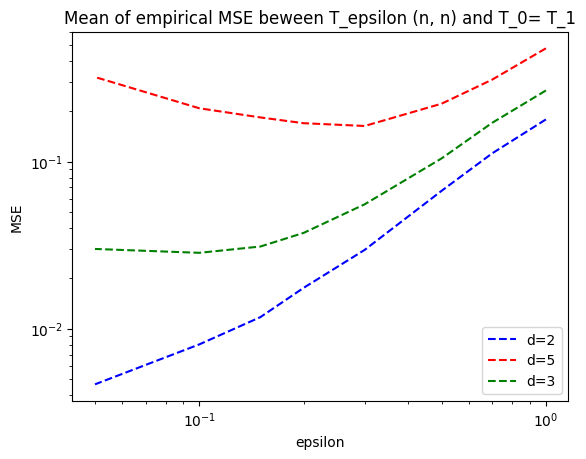

In [ ]:
plt.plot(epsilon_2_T1[0], epsilon_2_T1[1], 'b--', label ="d=2")
plt.plot(epsilon_5_T1[0], epsilon_5_T1[1], 'r--', label ="d=5")
plt.plot(epsilon_3_T1[0], epsilon_3_T1[1], 'g--', label ="d=3")
plt.legend()
plt.title('Mean of empirical MSE beween T_epsilon (n, n) and T_0= T_1')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('MSE')
plt.legend()
plt.show()

We remark that for $d=2$, and $d=3$, the lower epsilon is, the lower the empirical MSE is. With $d=5$, we can suppose that $200$ data points are not enough to train well the entropic map, so the decrease of the MSE is less obvious when $\epsilon$ decreases. 

In [ ]:
epsilon_2_T2 = experiment_epsilon(T = T_2, d = 2, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
epsilon_3_T2 = experiment_epsilon(T = T_2, d = 3, nombre_tirage = 20, n_monte_carlo=1000)

In [ ]:
epsilon_5_T2 = experiment_epsilon(T = T_2, d = 5, nombre_tirage = 20, n_monte_carlo=1000)

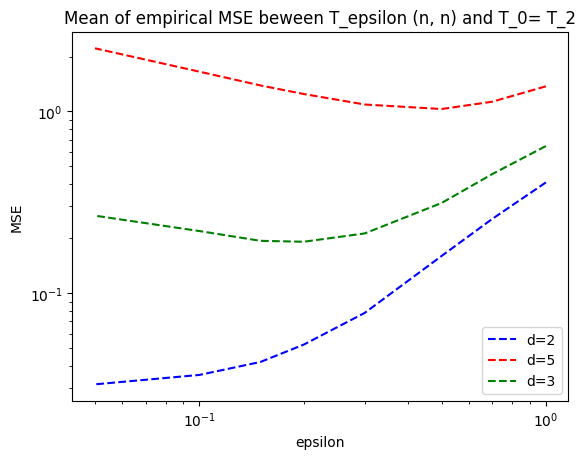

In [ ]:
plt.plot(epsilon_2_T2[0], epsilon_2_T2[1], 'b--', label ="d=2")
plt.plot(epsilon_5_T2[0], epsilon_5_T2[1], 'r--', label ="d=5")
plt.plot(epsilon_3_T2[0], epsilon_3_T2[1], 'g--', label ="d=3")
plt.legend()
plt.title('Mean of empirical MSE beween T_epsilon (n, n) and T_0= T_2')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('MSE')
plt.legend()
plt.show()

https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/gromov_wasserstein_multiomics.html

In [ ]:
X = np.load("SCOT/data/scatac_feat.npy")
y = np.load("SCOT/data/scrna_feat.npy")

print("Dimensions of input datasets:")
print(
    "X =",
    X.shape,
    "=> ie",
    X.shape[0],
    "samples belonging to a chromatin accessibility feature space of dimension",
    X.shape[1],
)
print(
    "y =",
    y.shape,
    "=> ie",
    y.shape[0],
    "samples belonging to a gene expression feature space of dimension",
    y.shape[1],
)

# Experiments on real data:

## Transforming digits with Binary alpha digit

This toy example is made to compute the optimal way to deform a digit to get another digit from the MNIST database.

Here we represent a one as a discrete source-distribution and we consider a zero as the target distribution.

The idea is to compute the entropic map between a one and a zero and to transport another one using this map. This method may have applications in image generation, especially in handwritten text generation. 

In [ ]:
mnist = pd.read_csv('sample_data/mnist_test.csv')
zero_train = mnist.iloc[2,1:].to_numpy()
zero_train = zero_train /np.sum(zero_train)
one_train = mnist.iloc[1,1:].to_numpy()
one_train = one_train /np.sum(one_train)
one_test = mnist.iloc[4,1:].to_numpy()
one_test = one_test /np.sum(one_test)


In [ ]:
def generate_data(digit):
  digit = jnp.array(digit)
  a=digit[digit !=0]
  x=np.zeros([len(a), 2])
  j=0
  for i in range (len(digit)):
    if digit[i]!=0:
      x[j,0] = i%28
      x[j,1] = i//28
      j+=1
  x = jnp.array(x)
  return x, a

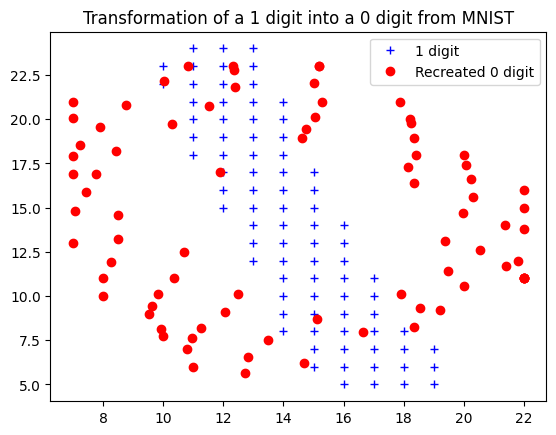

In [ ]:
y_zero, b_zero = generate_data(zero_train)
x_one, a_one = generate_data(one_train)
x_test, a_test = generate_data(one_test)

rng = jax.random.PRNGKey(42)
rng1 = jax.random.PRNGKey(123)



geometrie = pointcloud.PointCloud( x = x_one, y = y_zero, epsilon = 0.1)
problem = linear_problem.LinearProblem(geom = geometrie, a=a_one, b=b_zero)
solver = sinkhorn.Sinkhorn()
ot_sink = solver(problem)

entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = problem)
y_eps = entropic_pot.transport(vec = x_test)

plt.plot(x_test[:,0], x_test[:,1], 'b+', label = "1 digit")
plt.plot(y_eps[:,0], y_eps[:,1], 'ro', label = "Recreated 0 digit")
plt.title("Transformation of a 1 digit into a 0 digit from MNIST")
plt.legend()
plt.show()

## Prediction on the south-east-californian cats leaving their household

On average, an American household owns 1.5 cats. Because of this huge number, a large number of cats are lost every year in the United States.
According to the main results of the American Pet Products Association (APPA) and the American Society for the Prevention of Cruelty to Animals (ASPCA), we construct a plausible distribution of the cats leaving their household in the sud-east of California, according to our database (California housing). We then simulate their destination, and calculate the optimal transport map .

In [ ]:
DATA_TRAIN_PATH = '/content/sample_data/california_housing_train.csv'
data_train = pd.read_csv(DATA_TRAIN_PATH)
data_house = pd.DataFrame(columns = ['latitude', 'longitude','leaving_cats'])
data_house['latitude'] = data_train['latitude']
data_house['longitude'] = data_train['longitude']
data_house['leaving_cats'] = data_train['households']*0.05*1.5
ndata = data_house['latitude'].size

In [ ]:
sel_10 = random.sample(range(0,ndata//2),60)
sel_11 = random.sample(range(ndata//2+1, ndata),0)
sel_20 = random.sample(range(0,ndata//2),40)
sel_21 = random.sample(range(ndata//2+1, ndata),20)

data_train_start = data_house.iloc[sel_10+sel_11]
data_train_test = data_house.iloc[sel_20+sel_21]

a = np.array(data_train_start['leaving_cats'])
b = np.array(data_train_test['leaving_cats'])
a, b = a/a.sum(), b/b.sum()
start, end = np.zeros((60,2)), np.zeros((60,2))
for i,z in enumerate(np.array(data_train_start['latitude'])):
  start[i][0], start[i][1] = z, np.array(data_train_start['longitude'])[i]
  end[i][0], end[i][1] = np.array(data_train_test['latitude'])[i], np.array(data_train_test['longitude'])[i]

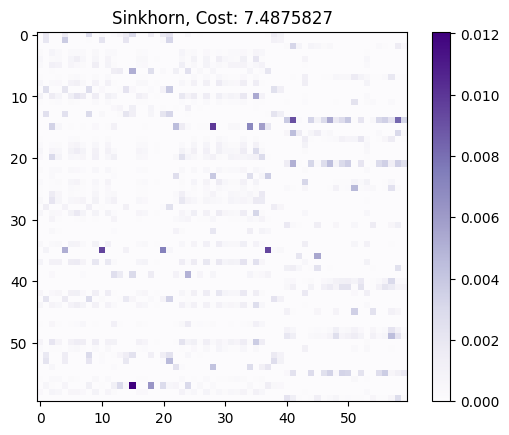

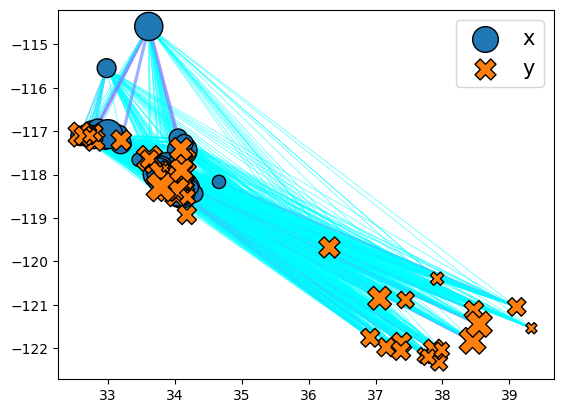

In [ ]:
geom = pointcloud.PointCloud(start, end, epsilon=0.1)
ot_prob = linear_problem.LinearProblem(geom, a, b)

solver = sinkhorn.Sinkhorn()
ot_sink = solver(ot_prob)

transp_cost = jnp.sum(ot_sink.matrix * geom.cost_matrix)
plt.imshow(ot_sink.matrix, cmap="Purples")
plt.title("Sinkhorn, Cost: " + str(transp_cost))
plt.colorbar()
plt.show()
plott = plot.Plot()
_ = plott(ot_sink)

Now that we have the optimal transport map, we can draw an new sample from our data, of new leaving cats. We apply our transport function to predict their main destination accross California.

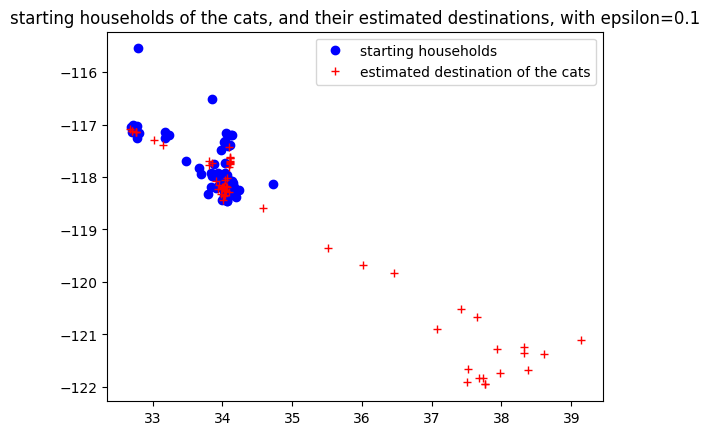

In [ ]:
sel_20 = random.sample(range(0,ndata//2),60)
sel_21 = random.sample(range(ndata//2+1, ndata),0)

data_test_start = data_house.iloc[sel_20+sel_21]
a = np.array(data_train_start['leaving_cats'])
a = a/a.sum()

x = np.zeros((60,2))
for i,z in enumerate(np.array(data_test_start['latitude'])):
  x[i][0], x[i][1] = z, np.array(data_test_start['longitude'])[i]

entropic_pot = potentials.EntropicPotentials(f_xy = ot_sink.f, g_xy = ot_sink.g, prob = ot_prob)
cats_predictions = entropic_pot.transport(vec = x)

plt.plot(x[:,0], x[:,1], 'bo', label = "starting households")
plt.plot(cats_predictions[:,0], cats_predictions[:,1], 'r+', label = "estimated destination of the cats")
plt.title("starting households of the cats, and their estimated destinations, with epsilon=0.1")
plt.legend()
plt.show()

Now, let's plot our prediction on the real Californian map to get a good idea of the issues at stake. We get the Californian map at http://eams2.usfs.msu.edu/study/zz/states_21basic/

In [ ]:
if "google.colab" in sys.modules:
    %pip install -q geopandas
    %pip install -q contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 41.7 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd

df_start = pd.DataFrame({'Latitude': x[:,0],'Longitude': x[:,1]})
df_predicted = pd.DataFrame({'Latitude': cats_predictions[:,0],'Longitude': cats_predictions[:,1]})
gdf_start = gpd.GeoDataFrame(df_start, geometry=gpd.points_from_xy(df_start.Longitude, df_start.Latitude))
gdf_predicted = gpd.GeoDataFrame(df_predicted, geometry=gpd.points_from_xy(df_predicted.Longitude, df_predicted.Latitude))

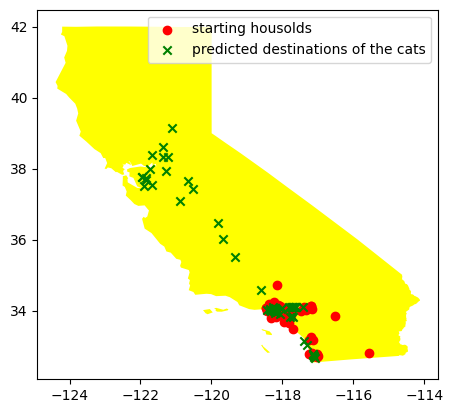

In [ ]:
ax = usa[24:25].plot(color="yellow")
gdf_start.plot(ax=ax, color='red', label="starting housolds")
gdf_predicted.plot(ax=ax, color='green', marker = "x", label = "predicted destinations of the cats")
plt.legend()
plt.show()